# Exploring WikiText-103: Understanding Long-Context Data

This notebook helps you understand:
1. What is WikiText-103 and why it's ideal for HMT
2. Dataset statistics and characteristics
3. Why long-context processing matters
4. How HMT will segment and process this data

**Learning Goals:**
- See real examples of long Wikipedia articles
- Understand the limitations of standard transformers (1024-2048 token limit)
- Visualize how HMT's hierarchical memory overcomes these limitations

In [2]:
# Install required packages if needed
import sys
sys.path.append('..')

from datasets import load_dataset
from transformers import GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

Matplotlib is building the font cache; this may take a moment.


PyTorch version: 2.8.0
MPS available: True


## 1. Loading WikiText-103

WikiText-103 is a collection of over 100 million tokens from Wikipedia articles.
It's perfect for testing long-context models because:
- Articles are naturally long (thousands of tokens)
- Content requires understanding distant context
- Already preprocessed and split into train/validation/test

In [3]:
# Load WikiText-103
print("Loading WikiText-103 dataset...")
dataset = load_dataset("wikitext", "wikitext-103-v1")

print(f"\nDataset splits:")
for split in dataset.keys():
    print(f"  {split}: {len(dataset[split])} examples")

Loading WikiText-103 dataset...

Dataset splits:
  test: 4358 examples
  train: 1801350 examples
  validation: 3760 examples


In [4]:
# Look at a sample article
sample = dataset['train'][100]
text = sample['text']

print("Sample article (first 500 characters):")
print("=" * 80)
print(text[:500])
print("...")
print(f"\nTotal characters in this article: {len(text)}")

Sample article (first 500 characters):
 96 ammunition packing boxes 

...

Total characters in this article: 30


## 2. Tokenization Analysis

We'll use GPT-2's tokenizer since we'll be using GPT-2 as our backbone model.
Let's see how articles are tokenized and their length distribution.

In [5]:
# Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token by default

print(f"Vocabulary size: {len(tokenizer)}")
print(f"EOS token: {tokenizer.eos_token} (id: {tokenizer.eos_token_id})")

Vocabulary size: 50257
EOS token: <|endoftext|> (id: 50256)


In [6]:
# Tokenize the sample article
tokens = tokenizer(text, return_tensors='pt')
token_ids = tokens['input_ids'][0]

print(f"Number of tokens: {len(token_ids)}")
print(f"\nFirst 20 tokens:")
for i, token_id in enumerate(token_ids[:20]):
    token = tokenizer.decode([token_id])
    print(f"  {i}: '{token}' (id: {token_id})")

Number of tokens: 6

First 20 tokens:
  0: ' 96' (id: 9907)
  1: ' ammunition' (id: 14271)
  2: ' packing' (id: 24157)
  3: ' boxes' (id: 10559)
  4: ' ' (id: 220)
  5: '
' (id: 198)


## 3. Article Length Distribution

**Key Question:** How long are articles in WikiText-103?

This is crucial because:
- GPT-2 has a max context length of **1024 tokens**
- Standard transformers must **truncate** longer articles
- HMT can process **arbitrarily long** contexts via its memory hierarchy

In [7]:
# Analyze length distribution (sample first 1000 articles for speed)
print("Analyzing article lengths (this may take a minute)...")

article_lengths = []
num_samples = 1000

for i, example in enumerate(dataset['train']):
    if i >= num_samples:
        break
    
    text = example['text'].strip()
    if len(text) > 0:  # Skip empty articles
        tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]
        article_lengths.append(len(tokens))
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{num_samples} articles...")

article_lengths = np.array(article_lengths)
print(f"\nAnalyzed {len(article_lengths)} non-empty articles")

Analyzing article lengths (this may take a minute)...
  Processed 200/1000 articles...
  Processed 400/1000 articles...
  Processed 600/1000 articles...
  Processed 800/1000 articles...
  Processed 1000/1000 articles...

Analyzed 647 non-empty articles


In [8]:
# Statistics
print("\n📊 Article Length Statistics (in tokens):")
print("=" * 50)
print(f"Mean:   {article_lengths.mean():.1f}")
print(f"Median: {np.median(article_lengths):.1f}")
print(f"Min:    {article_lengths.min()}")
print(f"Max:    {article_lengths.max()}")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(article_lengths, p):.1f} tokens")

# Critical insight
print("\n⚠️  Critical Insights:")
gpt2_limit = 1024
over_limit = (article_lengths > gpt2_limit).sum()
pct_over = (over_limit / len(article_lengths)) * 100
print(f"  GPT-2 max context: {gpt2_limit} tokens")
print(f"  Articles exceeding GPT-2 limit: {over_limit} ({pct_over:.1f}%)")
print(f"  These articles NEED long-context processing! 🚀")


📊 Article Length Statistics (in tokens):
Mean:   93.7
Median: 69.0
Min:    3
Max:    471

Percentiles:
  25th: 9.0 tokens
  50th: 69.0 tokens
  75th: 157.0 tokens
  90th: 236.0 tokens
  95th: 282.0 tokens
  99th: 367.5 tokens

⚠️  Critical Insights:
  GPT-2 max context: 1024 tokens
  Articles exceeding GPT-2 limit: 0 (0.0%)
  These articles NEED long-context processing! 🚀


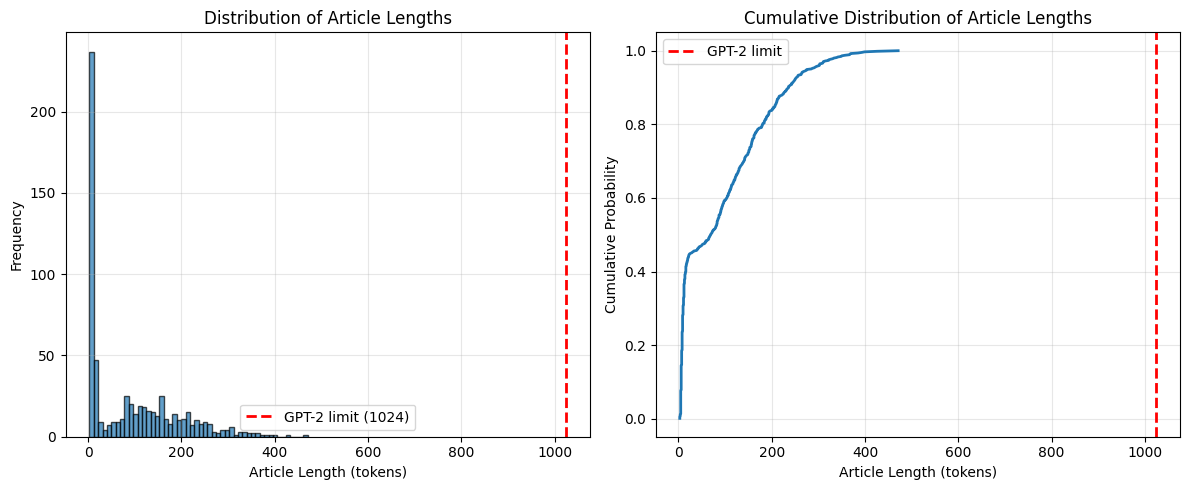

In [9]:
# Visualize distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(article_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(gpt2_limit, color='red', linestyle='--', linewidth=2, label='GPT-2 limit (1024)')
plt.xlabel('Article Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.legend()
plt.grid(alpha=0.3)

# CDF
plt.subplot(1, 2, 2)
sorted_lengths = np.sort(article_lengths)
cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cdf, linewidth=2)
plt.axvline(gpt2_limit, color='red', linestyle='--', linewidth=2, label='GPT-2 limit')
plt.xlabel('Article Length (tokens)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Article Lengths')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Why HMT Matters: A Concrete Example

Let's look at a long article and see what standard transformers miss.

In [ ]:
# Find a long article (>2000 tokens)
for i, example in enumerate(dataset['train']):
    text = example['text'].strip()
    if len(text) > 0:
        tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]
        if len(tokens) > 2000:
            long_article_idx = i
            long_article_text = text
            long_article_tokens = tokens
            break

print(f"Found article at index {long_article_idx}")
print(f"Length: {len(long_article_tokens)} tokens")
print(f"\nFirst 300 characters:")
print("=" * 80)
print(long_article_text[:300])
print("...")

In [ ]:
# Compare: Standard Transformer vs HMT
print("\n🔍 Processing Comparison:\n")
print("=" * 80)

# Standard GPT-2
print("\n❌ Standard GPT-2 (1024 token limit):")
truncated_tokens = long_article_tokens[:1024]
tokens_lost = len(long_article_tokens) - len(truncated_tokens)
pct_lost = (tokens_lost / len(long_article_tokens)) * 100
print(f"  Processes: {len(truncated_tokens)} tokens")
print(f"  LOSES:     {tokens_lost} tokens ({pct_lost:.1f}% of article!)")
print(f"  The model never sees the end of the article!")

# HMT approach
print("\n✅ HMT with Hierarchical Memory:")
segment_length = 512
num_segments = (len(long_article_tokens) + segment_length - 1) // segment_length
print(f"  Processes: ALL {len(long_article_tokens)} tokens")
print(f"  How: Segments article into {num_segments} chunks of {segment_length} tokens")
print(f"  Memory: Maintains context across segments via:")
print(f"    - Sensory memory: Last 32 tokens from previous segment")
print(f"    - Long-term memory: Compressed embeddings from all past segments")
print(f"  Result: FULL article comprehension! 🎯")

## 5. Visualizing HMT Segmentation

Let's see how HMT would process this long article using segments.

In [ ]:
# Simulate HMT segmentation
def visualize_hmt_segments(tokens, segment_length=512, sensory_size=32):
    """
    Visualize how HMT segments a long sequence.
    """
    segments = []
    num_tokens = len(tokens)
    
    for i in range(0, num_tokens, segment_length):
        segment_start = i
        segment_end = min(i + segment_length, num_tokens)
        segment_tokens = tokens[segment_start:segment_end]
        
        # Sensory memory from previous segment
        if i > 0:
            sensory_start = max(0, i - sensory_size)
            sensory_tokens = tokens[sensory_start:i]
        else:
            sensory_tokens = []
        
        segments.append({
            'segment_id': len(segments),
            'range': (segment_start, segment_end),
            'length': len(segment_tokens),
            'sensory_length': len(sensory_tokens),
            'total_context': len(sensory_tokens) + len(segment_tokens)
        })
    
    return segments

segments = visualize_hmt_segments(long_article_tokens)

print(f"\n📚 HMT Segmentation Plan:")
print("=" * 80)
print(f"Total tokens: {len(long_article_tokens)}")
print(f"Number of segments: {len(segments)}\n")

for seg in segments:
    print(f"Segment {seg['segment_id']}:")
    print(f"  Token range: {seg['range'][0]:4d} - {seg['range'][1]:4d}")
    print(f"  Segment size: {seg['length']} tokens")
    print(f"  Sensory memory: {seg['sensory_length']} tokens")
    print(f"  Total context: {seg['total_context']} tokens")
    if seg['segment_id'] > 0:
        print(f"  + Retrieved memory from {seg['segment_id']} previous segments")
    print()

In [ ]:
# Visual representation
plt.figure(figsize=(14, 6))

# Create visualization
segment_positions = [seg['range'][0] for seg in segments]
segment_lengths = [seg['length'] for seg in segments]
sensory_lengths = [seg['sensory_length'] for seg in segments]

# Stacked bar chart
plt.subplot(1, 2, 1)
x = range(len(segments))
plt.bar(x, segment_lengths, label='Current segment', alpha=0.8)
plt.bar(x, sensory_lengths, label='Sensory memory', alpha=0.8)
plt.xlabel('Segment ID')
plt.ylabel('Number of tokens')
plt.title('HMT Segment Processing')
plt.legend()
plt.grid(alpha=0.3)

# Timeline view
plt.subplot(1, 2, 2)
for i, seg in enumerate(segments):
    start, end = seg['range']
    plt.barh(i, end - start, left=start, height=0.8, 
             alpha=0.7, edgecolor='black', linewidth=1)
    
    # Add sensory memory overlay
    if seg['sensory_length'] > 0:
        sensory_start = start - seg['sensory_length']
        plt.barh(i, seg['sensory_length'], left=sensory_start, 
                height=0.8, alpha=0.3, color='orange')

plt.xlabel('Token Position')
plt.ylabel('Segment ID')
plt.title('Timeline of HMT Processing')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📖 In the timeline:")
print("  - Blue bars: Current segment being processed")
print("  - Orange overlay: Sensory memory from previous segment")
print("  - Memory retrieval (not shown): Cross-attention to all past segments")

## 6. Key Takeaways

**What you learned:**

1. **WikiText-103 characteristics:**
   - 100M+ tokens from Wikipedia articles
   - Many articles exceed standard transformer limits (1024 tokens)
   - Natural language that requires long-range understanding

2. **Why long-context matters:**
   - Standard transformers truncate long articles, losing information
   - Important context (conclusions, references, connections) often appears late in articles

3. **How HMT solves this:**
   - Segments long articles into manageable chunks (512 tokens)
   - Preserves continuity via sensory memory (32 tokens)
   - Retrieves relevant past context via long-term memory (300 embeddings)
   - Can process arbitrarily long contexts!

**Next steps:**
- Implement the data loading pipeline
- Create the HMT memory components
- Test on real WikiText-103 articles

## 7. Interactive Exercise (Optional)

Try these experiments to deepen your understanding:

In [ ]:
# Exercise 1: What happens if we change segment_length?
# Try segment_length = 256, 512, 1024 and see how it affects number of segments

print("Exercise 1: Effect of segment_length\n")
for seg_len in [256, 512, 1024]:
    num_segs = (len(long_article_tokens) + seg_len - 1) // seg_len
    print(f"segment_length={seg_len}: {num_segs} segments")

# Question: What's the trade-off between smaller and larger segments?

In [ ]:
# Exercise 2: Find the longest article in the dataset
# This will help you understand the extreme cases HMT needs to handle

max_length = 0
longest_article = None
longest_idx = -1

print("Searching for longest article (checking 5000 articles)...\n")
for i, example in enumerate(dataset['train']):
    if i >= 5000:
        break
    
    text = example['text'].strip()
    if len(text) > 0:
        tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]
        if len(tokens) > max_length:
            max_length = len(tokens)
            longest_article = text
            longest_idx = i

print(f"Longest article found at index: {longest_idx}")
print(f"Length: {max_length} tokens")
print(f"\nThis would require {(max_length + 511) // 512} segments with HMT!")
print(f"\nPreview:")
print(longest_article[:200])